# Byte Me ~ Sentiment Analysis

# Data Preparation

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv('imdb.csv')
df.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
df.duplicated().sum()

np.int64(418)

In [4]:
df = df.drop_duplicates(subset='review').reset_index(drop=True)

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_review(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)              # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)           # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()       # Normalize whitespace
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)


In [6]:
df['clean_review'] = df['review'].apply(preprocess_review)
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [ ]:
df.head()

,review,sentiment,clean_review,label
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,1


In [ ]:
from collections import Counter
def get_word_counts(text_series):
    all_tokens = []
    for text in text_series:
        tokens = word_tokenize(text)
        all_tokens.extend(tokens)
    return Counter(all_tokens)

In [ ]:
pos_reviews = df[df['label'] == 1]['clean_review']
neg_reviews = df[df['label'] == 0]['clean_review']

In [ ]:
pos_counts = get_word_counts(pos_reviews)
neg_counts = get_word_counts(neg_reviews)

In [ ]:
def plot_top_words(counter, title, n=20):
    common = counter.most_common(n)
    words, counts = zip(*common)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

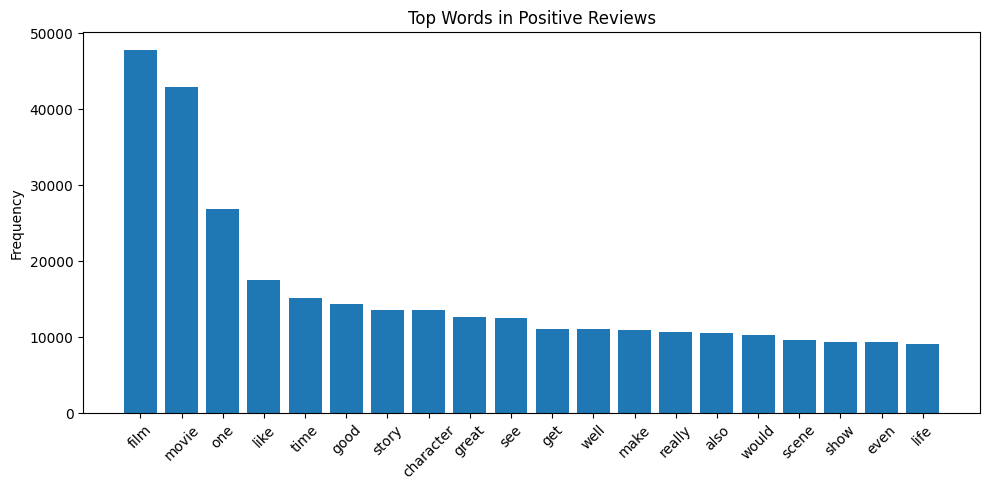

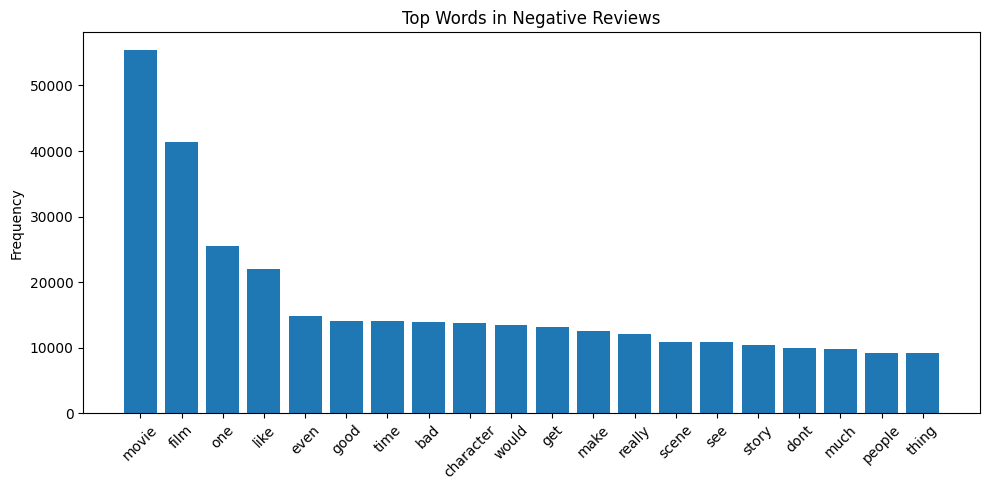

In [ ]:
plot_top_words(pos_counts, "Top Words in Positive Reviews")
plot_top_words(neg_counts, "Top Words in Negative Reviews")

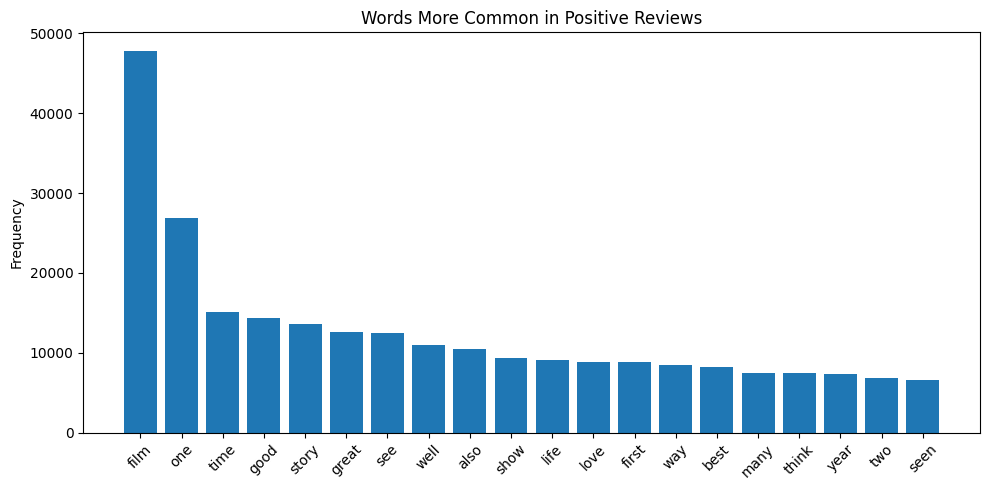

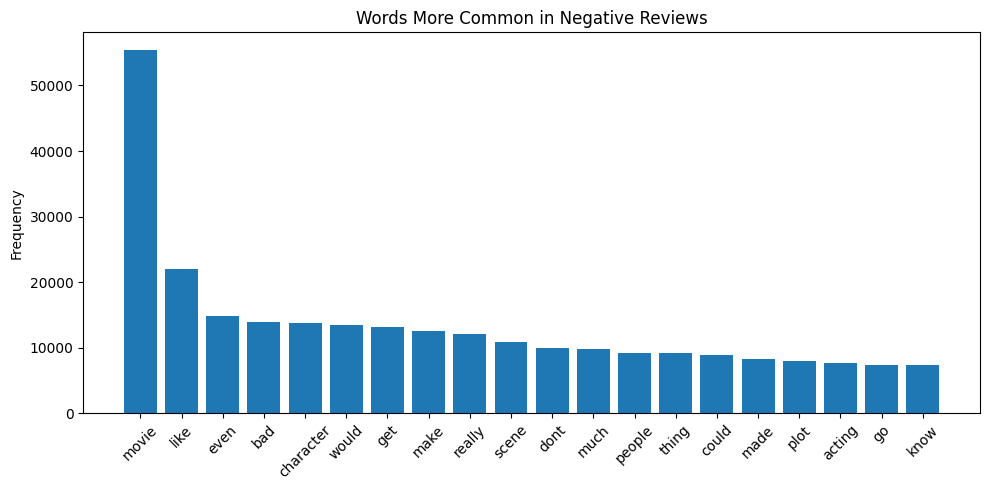

In [ ]:
from operator import neg
pos_diff = Counter({
    word: count for word, count in pos_counts.items()
    if count > neg_counts.get(word, 0)
})
neg_diff = Counter({
    word: count for word, count in neg_counts.items()
    if count > pos_counts.get(word, 0)
})
plot_top_words(pos_diff, "Words More Common in Positive Reviews")
plot_top_words(neg_diff, "Words More Common in Negative Reviews")

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the entire dataframe
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# train and test
X_train_text = df_train['clean_review']
X_test_text = df_test['clean_review']
y_train = df_train['label']
y_test = df_test['label']

# keep access to original reviews
X_train_orig = df_train['review']
X_test_orig = df_test['review']

# TF-IDF transformation
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)


In [8]:
vocab_size = len(tfidf.vocabulary_)
print("Vocabulary size:", vocab_size)

Vocabulary size: 175667


In [17]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# Data Analysis

## Classification Models

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8913986084501361


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
accuracy_scores = {}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear Kernel)": SVC(kernel='linear',probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

for name, clf in classifiers.items():
    print(f"\n{name}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = acc


Logistic Regression
Accuracy: 0.8914
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4939
           1       0.88      0.91      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917


Naive Bayes
Accuracy: 0.8641
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4939
           1       0.87      0.86      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917


SVM (Linear Kernel)
Accuracy: 0.8927
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4939
           1       0.88      0.90      0.89      4978

    acc

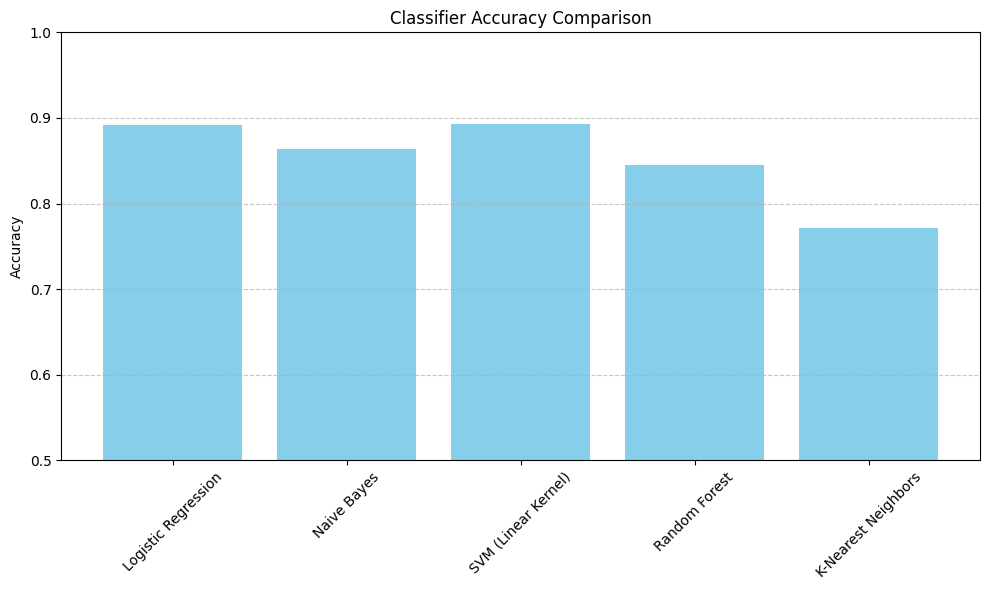

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

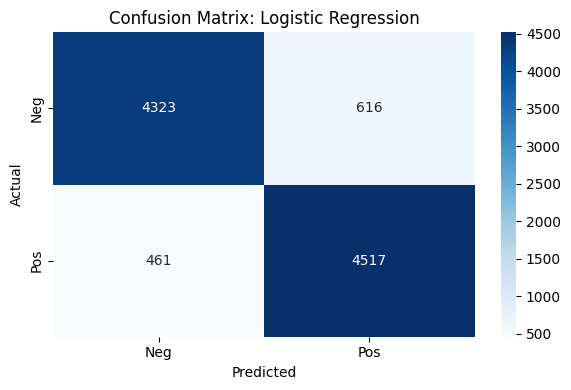

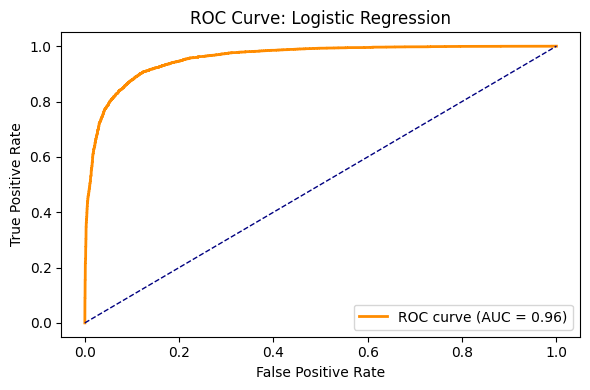

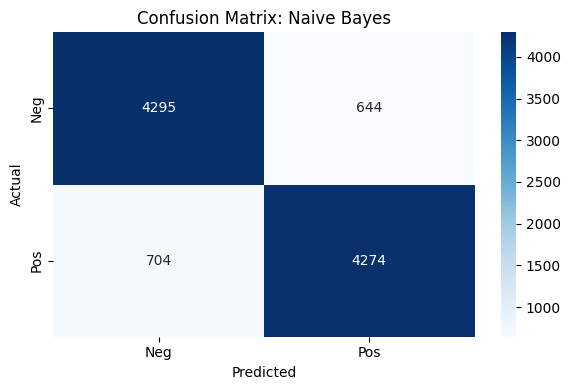

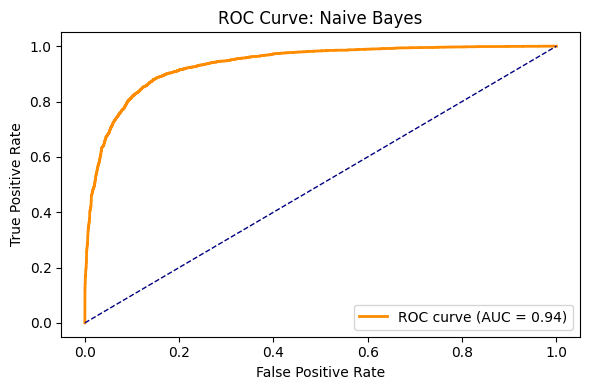

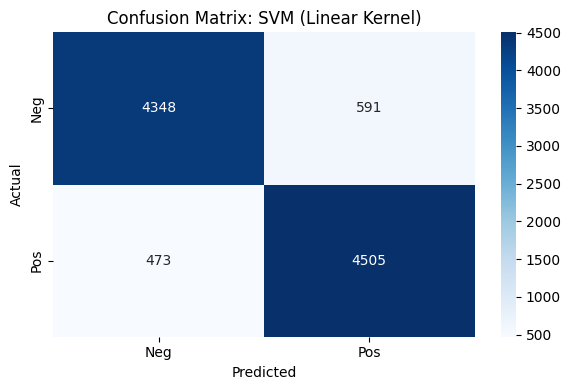

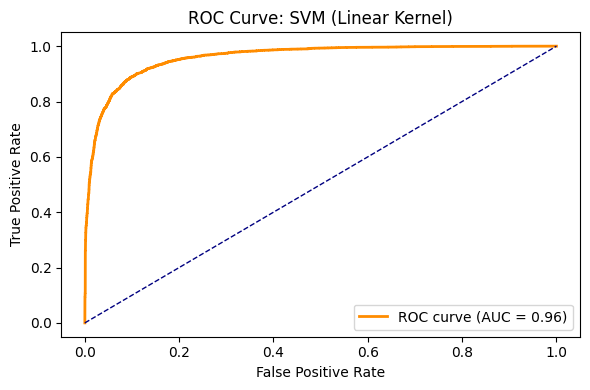

In [ ]:
selected_models = ["Logistic Regression", "Naive Bayes", "SVM (Linear Kernel)"]

for name in selected_models:
    clf = classifiers[name]
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # conf matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.show()

    # ROC
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_scores = clf.decision_function(X_test)
    else:
        print(f"No probability output available for {name}")
        continue

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [ ]:
# HP tuning for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='roc_auc')
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
y_pred = best_lr.predict(X_test)
y_scores = best_lr.predict_proba(X_test)[:, 1]  # probability for class 1

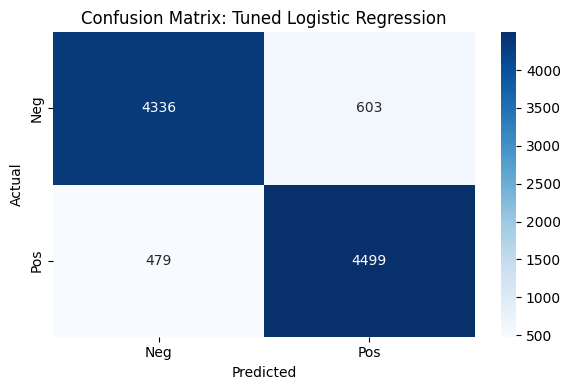

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Tuned Logistic Regression')
plt.tight_layout()
plt.show()


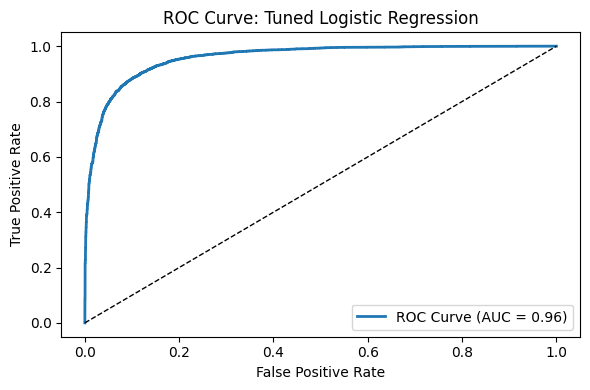

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4939
    Positive       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'loss': ['hinge'],
    'dual': [True],
    'max_iter': [5000, 10000]
}

svm = LinearSVC()

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

best_svm = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 1, 'dual': True, 'loss': 'hinge', 'max_iter': 5000, 'penalty': 'l2'}
Best CV Accuracy: 0.8903315664392336


In [ ]:
# Predict and evaluate
y_pred = best_svm.predict(X_test)
y_scores = best_svm.decision_function(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8927094887566804


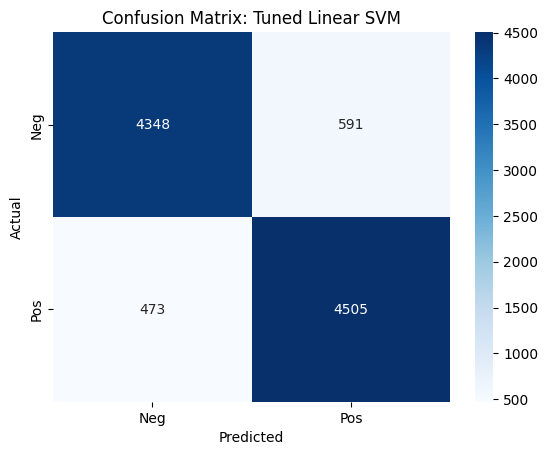

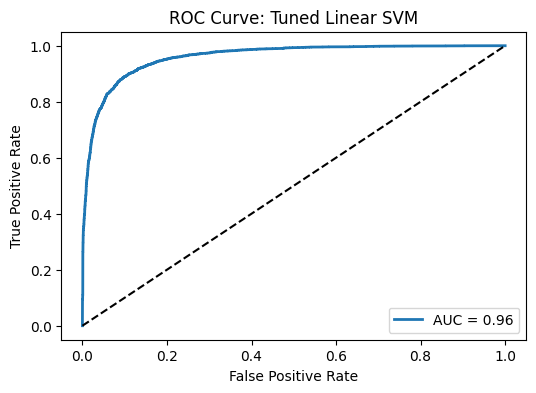

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4939
    Positive       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title("Confusion Matrix: Tuned Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Tuned Linear SVM")
plt.legend(loc='lower right')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


In [ ]:
from google.colab import files
import joblib

joblib.dump(best_svm, 'svm_model.pkl')

files.download('svm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import joblib
best_svm = joblib.load('svm_model.pkl')
y_pred = best_svm.predict(X_test)
y_scores = best_svm.decision_function(X_test)

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
# Create result labels
y_true = np.array(y_test)
y_pred = np.array(y_pred)

results = []
for i in range(len(y_true)):
    if y_true[i] == 1 and y_pred[i] == 1:
        label = "TP"
    elif y_true[i] == 0 and y_pred[i] == 0:
        label = "TN"
    elif y_true[i] == 0 and y_pred[i] == 1:
        label = "FP"
    elif y_true[i] == 1 and y_pred[i] == 0:
        label = "FN"
    else:
        label = "UNKNOWN"
    results.append(label)

df_results = pd.DataFrame({
    "text": X_test_orig,
    "true_label": y_true,
    "pred_label": y_pred,
    "result": results
})

# Display examples
print("True Positives")
display(df_results[df_results.result == "TP"].head())

print("False Positives")
display(df_results[df_results.result == "FP"].head())

print("True Negatives")
display(df_results[df_results.result == "TN"].head())

print("False Negatives")
display(df_results[df_results.result == "FN"].head())


True Positives


text  \
43282                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Guest from the Future tells a fascinating story of time travel, friendship, battle of good and evil -- all with a small budget, child actors, and few special effects. Something for Spielberg and Lucas to learn from. ;) A sixth-grader Kolya "Nick" Gerasimov finds a time machine in the basement of a decrepit building and travels 100 years into the future. He discovers a near-perfect, utopian society where robots play guitars and write poetry, everyone is kind to each other and people enjoy everything technology has to offer. Alice is the daughter of a prominent scientist who invented a device called Mielophone that allows to read minds of humans and animals. The device can be put to both good and bad use, depending on whose hands it falls into. When two evil space pirates from Saturn who want to rule the universe attempt to steal Mielophone, it falls into the hands of 20th century school boy Nick. With the pirates hot on his tracks, he travels back to his time, followed by the pirates, and Alice. Chaos, confusion and funny situations follow as the luckless pirates try to blend in with the earthlings. Alice enrolls in the same school Nick goes to and demonstrates superhuman abilities in PE class. The catch is, Alice doesn't know what Nick looks like, while the pirates do. Also, the pirates are able to change their appearance and turn l

False Positives


,text,true_label,pred_label,result
38461,"""National Treasure"" (2004) is a thoroughly misguided hodge-podge of plot entanglements that borrow from nearly every cloak and dagger government conspiracy cliché that has ever been written. The film stars Nicholas Cage as Benjamin Franklin Gates (how precious is that, I ask you?); a seemingly normal fellow who, for no other reason than being of a lineage of like-minded misguided fortune hunters, decides to steal a 'national treasure' that has been hidden by the United States founding fathers. After a bit of subtext and background that plays laughably (unintentionally) like Indiana Jones meets The Patriot, the film degenerates into one misguided whimsy after another  attempting to create a 'Stanley Goodspeed' regurgitation of Nicholas Cage and launch the whole convoluted mess forward with a series of high octane, but disconnected misadventures.<br /><br />The relevancy and logic to having George Washington and his motley crew of patriots burying a king's ransom someplace on native soil, and then, going through the meticulous plan of leaving clues scattered throughout U.S. currency art work, is something that director Jon Turteltaub never quite gets around to explaining. Couldn't Washington found better usage for such wealth during the start up of the country? Hence, we are left with a mystery built on top of an enigma that is already on shaky ground by the time Ben appoints himself the new custodian of this untold wealth. Ben's intentions are noble  if confusing. He's set on protecting the treasure. For who and when? your guess is as good as mine.<br /><br />But there are a few problems with Ben's crusade. First up, his friend, Ian Holmes (Sean Bean) decides that he can't wait for Ben to make up his mind about stealing the Declaration of Independence from the National Archives (oh, yeah  brilliant idea!). Presumably, the back of that famous document holds the secret answer to the ultimate fortune. So Ian tries to kill Ben. The assassination attempt is, of course, unsuccessful, if overly melodramatic. It also affords Ben the opportunity to pick up, and pick on, the very sultry curator of the archives, Abigail Chase (Diane Kruger). She thinks Ben is clearly a nut  at least at the beginning. But true to action/romance form, Abby's resolve melts quicker than you can say, ""is that the Hope Diamond?"" The film moves into full X-File-ish mode, as the FBI, mistakenly believing that Ben is behind the theft, retaliate in various benign ways that lead to a multi-layering of action sequences reminiscent of Mission Impossible meets The Fugitive. Honestly, don't those guys ever get 'intelligence' information that is correct? In the final analysis, ""National Treasure"" isn't great film making, so much as it's a patchwork rehash of tired old bits from other movies, woven together from scraps, the likes of which would make IL' Betsy Ross blush.<br /><br />The Buena Vista DVD delivers a far more generous treatment than this film is deserving of. The anamorphic widescreen picture exhibits a very smooth and finely detailed image with very rich colors, natural flesh tones, solid blacks and clean whites. The stylized image is also free of blemishes and digital enhancements. The audio is 5.1 and delivers a nice sonic boom to your side and rear speakers with intensity and realism. Extras include a host of promotional junket material that is rather deep and over the top in its explanation of how and why this film was made. If only, as an audience, we had had more clarification as to why Ben and co. were chasing after an illusive treasure, this might have been one good flick. Extras conclude with the theatrical trailer, audio commentary and deleted scenes. Not for the faint-hearted  just the thick-headed.",0,1,FP
47410,"His significant charisma and commanding presence are about all that keep this afloat, but Fred Williamson has done far better urban action films including many of his later, vid-release

True Negatives


,text,true_label,pred_label,result
29035,"""Soul Plane"" is a horrible attempt at comedy that only should appeal people with thick skulls, bloodshot eyes and furry pawns. <br /><br />The plot is not only incoherent but also non-existent, acting is mostly sub sub-par with a gang of highly moronic and dreadful characters thrown in for bad measure, jokes are often spotted miles ahead and almost never even a bit amusing. This movie lacks any structure and is full of racial stereotypes that must have seemed old even in the fifties, the only thing it really has going for it is some pretty ladies, but really, if you want that you can rent something from the ""Adult"" section. OK?<br /><br />I can hardly see anything here to recommend since you'll probably have a lot a better and productive time chasing rats with a sledgehammer or inventing waterproof teabags or whatever.<br /><br />2/10",0,0,TN
16000,"OK. First said, I just wanted to check whether this movie has an average rating below or exactly -1. But 5,9. This is sicker than any of the killers' proceedings -,- . That made me curious what people wrote here.. which in the end made me set up an account to give my 2cents of truth into this ""well of delusion"" i find here.<br /><br />How dare you guys even MENTION this movie in the same sentences as e.g. Seven? The only thing they got in common is that they show various crime-scenes. That-is-it. And ""Best thriller of 1999!"" ? have you even watched another movie form that year? Or any other movie in your life at all? 1999 is not a year which people are reminded of by RESURRECTION... what's with actual MOVIES like 8mm, Eyes wide shut, Arlington Road, Double Jeopardy? (Theyre actually more a ""thriller"" than this one could ever be..). Resurrection does not even deserve to be dedicated to A SECOND of 1999.<br /><br />Really, you guys can't be serious. I watched that movie yesterday with my girlfriend, highly recommended by a friend of her. A ""great film with Christopher Lambert""! ...which I had not yet seen? Hmm.. <br /><br />Well, first look on the Covers: OK, nothing special. At second glimpse you don't need to have supernatural powers to be aware that they simply mirrored Lambert's head, clipped his nose 'n this&that, then made a fancy negative pattern on top of it, to get the killers image on the COVER. You could even think they had some apprentice eat a gallon of marshmallows just to caption that creepy (booooh! -.- ) mouth.. whatever. Turned it around and the plot starts with.. ""it's raining in Chicago... blabber blabber"". Come on, a six year old could have made that snippet sound more exciting. Now, with this enormous excitement coming from the movies terrific presentation -.- , you absolutely wanna start watching it. Because it can't be that bad, it still is Christopher Lambert. That assumption of mine was proved wrong. WIth ""proven wrong"" i mean it was brutally executed by a deadly mix of the worst imaginable acting ever known to mankind (every actor, but the tops are the ""i can do 1-Liners!"" police chief, Prudhommes Wife __ actually a better detective than Prudhomme when she recombines several incidents to a yet ABSOLUTELY UNKNOWN hint in the case!!!! -.- __ and .. yes.. Prudhomme himself) featuring a squadron of inhuman fake feelings, logic errors in a 1-minute-cycle, light-years far-fetched conclusions which in my point-of-view represent an insult to any thinking human being and last but not least a camera-man who obviously was a hyperventilating kangaroo. Oh well, and if you do not completely shut down your brains (these aren't premises to watch it) then you should know who is who and what is what after max. 30minutes, simply because you know ANY scene after the first. That is thrilling. Thrilling because this movie almost makes you think you can tell the future. <br /><br />The bottom line: This is BY FAR the worst movie I can remember. Trust me, I've seen many horrible movies which in some way were at least only

False Negatives


,text,true_label,pred_label,result
39877,"A horror movie is being shot and things aren't going well. It's about a masked killer. The director tells off the killer in front of the cast and crew. He goes crazy and kills two people. He's killed himself and the film is never finished. Twelve years later a bunch of film students decide to try and finish it--but there's a curse. People who try and finish it are killed themselves. The students ignore that. Guess what happens next?<br /><br />The plot is old hat but this isn't bad...for what it is (a low budget slasher film). It's well-made with a young and fairly talented young cast. No one is great but no one is terrible either. It also avoids the obligatory (and needless) female nude scenes. It moves quickly, the gore is nice and bloody and the script doesn't insult your intelligence. Also Molly Ringwald is in this having the time of her life playing a bitchy faded actress.<br /><br />No great shakes but not bad at all. I give it a 7.",1,0,FN
42613,"There is only one racist joke in this Daffy Duck short, which is basically, when Daffy rides Black Beauty, it is a black woman. I can understand partly why this joke was included, as at the time few people did not know how rude it was to be racist and it wasn't even illegal to discriminate black people yet.<br /><br />Aside from this point, ""A Coy Decoy"" is basically a fun, interesting short where Daffy meets characters in books and does things in books. I liked this short quite a lot (despite the other reviewers on here). The way Daffy is so in love with the clockwork duck is vaguely disturbing, yet highly amusing at the same time. Porky is a nice edition to the episode, though it was not vital for him to be there. The wolf is an example of how people thought of wolves in those days as well, blood-thirsty, terrible animals, which of course they never really have been (unless they are very hungry). I also liked the style of animation used - and the theme of the episode.<br /><br />For people who are totally into Daffy Duck and for people who do not mind the occasional racist joke in cartoons, enjoy ""A Coy Decoy""!<br /><br />Available on YouTube.",1,0,FN
3168,"I am always so frustrated that the majority of science fiction movies are really intergalactic westerns or war dramas. Even Star Wars which is visually brilliant, has one of its central images, a futuristic ""gang that couldn't shoot straight."" Imagine your coming upon about 600 people with conventional weapons, most of them having an open shot, and they miss.<br /><br />I have read much science fiction, and wish there were more movies for the thinking person. Forbidden Planet, one of the earliest of the genre, is still one of the very best. The story is based on a long extinct civilization, the Krell, who created machines which could boost the intelligence of any being by quantum leaps. Unfortunately, what they hadn't bargained for, is that the brain is a center for other thoughts than intellectual. The primitive aspect of the brain, the Id, as Freud called it, is allowed to go unchecked. It is released in sleep, a bad dream come to corporeal existence. Walter Pigeon, Dr. Morbius, is the one who has jacked his brain to this level, and with it has built machines and defenses that keep him barely one step ahead of the horrors of the recesses of his own mind. His thoughts are creating horrors that he soon will not be able to defend. The Krell, a much superior species, could not stop it; it destroyed them. The landing party has never been of great interest to me. The rest of the actors are pretty interchangeable. Ann Francis is beautiful and naive, and certainly would have produced quite a reaction in the fifties adolescent male. Her father's ire is exacerbated by her innocence and the wolfy fifties' astronauts (for they are more like construction workers on the make than real astronauts). They are always trying to figure out ""dames."" The cook is a great character, with his obs

## Neural Network

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#  vocab size
vocab_size = 10000
max_length = 500  # max tokens per review
oov_token = "<OOV>"

# tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

# fit tokenizer on training text
tokenizer.fit_on_texts(X_train_text)

# nonvert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# pad sequences to ensure we have uniform input sizing
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 64

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 363s 290ms/step - accuracy: 0.4997 - loss: 0.6935 - val_accuracy: 0.5017 - val_loss: 0.6931
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 406s 310ms/step - accuracy: 0.5016 - loss: 0.6931 - val_accuracy: 0.5022 - val_loss: 0.6932
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 439s 308ms/step - accuracy: 0.5016 - loss: 0.6940 - val_accuracy: 0.4982 - val_loss: 0.6937


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

embedding_dim = 64

cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 150s 117ms/step - accuracy: 0.7565 - loss: 0.4748 - val_accuracy: 0.8755 - val_loss: 0.2998
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 197s 114ms/step - accuracy: 0.9195 - loss: 0.2068 - val_accuracy: 0.8724 - val_loss: 0.3108
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9635 - loss: 0.1108 - val_accuracy: 0.8772 - val_loss: 0.3312


In [ ]:
model.evaluate(X_test_pad, y_test)

310/310 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.8683 - loss: 0.4080


[0.4143337905406952, 0.8717353940010071]

In [ ]:
cnn_model.evaluate(X_train_pad, y_train)

310/310 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8769 - loss: 0.2987


[0.29984015226364136, 0.8754663467407227]

LSTM Test Accuracy: 0.8717
CNN Test Accuracy: 0.8755


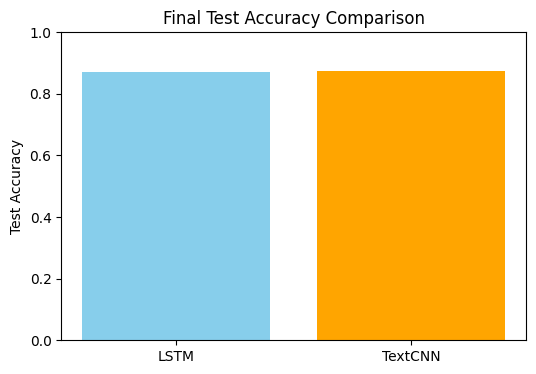

In [ ]:
test_loss_lstm, test_acc_lstm = model.evaluate(X_test_pad, y_test, verbose=0)
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Test Accuracy: {test_acc_lstm:.4f}")
print(f"CNN Test Accuracy: {test_acc_cnn:.4f}")
models = ['LSTM', 'TextCNN']
accuracies = [test_acc_lstm, test_acc_cnn]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.title('Final Test Accuracy Comparison')
plt.show()


In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_dim', [32, 64])
    ))

    model.add(Conv1D(
        filters=hp.Choice('num_filters', [64, 128]),
        kernel_size=hp.Choice('kernel_size', [3, 5]),
        activation='relu'
    ))

    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_dir',
    project_name='fast_cnn_tuning'
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(
    X_train_pad, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)


Trial 22 Complete [00h 03m 52s]
val_accuracy: 0.875961184501648

Best val_accuracy So Far: 0.8794907331466675
Total elapsed time: 01h 06m 13s


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for k, v in best_hps.values.items():
    print(f"{k}: {v}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_pad, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Best hyperparameters:
embedding_dim: 64
num_filters: 128
kernel_size: 3
optimizer: adam
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0010
Epoch 1/10
992/992 ━━━━━━━━━━━━━━━━━━━━ 77s 76ms/step - accuracy: 0.7553 - loss: 0.4874 - val_accuracy: 0.8674 - val_loss: 0.3042
Epoch 2/10
992/992 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.9117 - loss: 0.2223 - val_accuracy: 0.8782 - val_loss: 0.2908
Epoch 3/10
992/992 ━━━━━━━━━━━━━━━━━━━━ 87s 80ms/step - accuracy: 0.9634 - loss: 0.1161 - val_accuracy: 0.8743 - val_loss: 0.3249
Epoch 4/10
992/992 ━━━━━━━━━━━━━━━━━━━━ 78s 77ms/step - accuracy: 0.9896 - loss: 0.0487 - val_accuracy: 0.8742 - val_loss: 0.3821


In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8740


In [ ]:
import numpy as np

y_pred_probs = best_model.predict(X_test_pad).ravel()  # Probabilities
y_pred = (y_pred_probs >= 0.5).astype(int)             # Class labels


310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


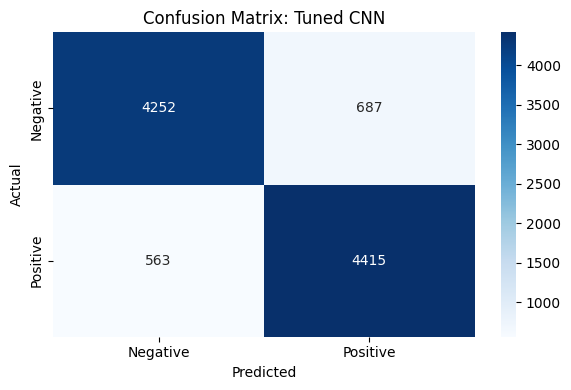

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Tuned CNN')
plt.tight_layout()
plt.show()


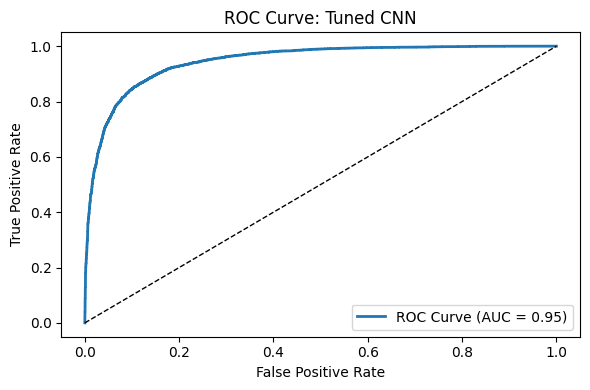

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Tuned CNN')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      4939
    Positive       0.87      0.89      0.88      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



In [ ]:
best_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 500, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 498, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,994,501 (7.61 MB)

 Trainable params: 664,833 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,329,668 (5.07 MB)